# Model Exploration

## Imports

In [2]:
# Generics dependencies
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from random import randint
from glob import glob

# Tensorflow dependencies
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.config.experimental import list_physical_devices, set_memory_growth

import tensorflow as tf
import tensorboard


### Configure GPU

[Procedure for handling GPU](https://www.tensorflow.org/install/gpu)

In [3]:
gpus = list_physical_devices('GPU')
print(gpus)

for gpu in gpus:
    set_memory_growth(gpu, True)

[]


2022-08-03 16:49:55.727015: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2022-08-03 16:49:55.727065: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: gio
2022-08-03 16:49:55.727076: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: gio
2022-08-03 16:49:55.727216: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.65.1
2022-08-03 16:49:55.727257: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.65.1
2022-08-03 16:49:55.727264: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 515.65.1


### Data samples

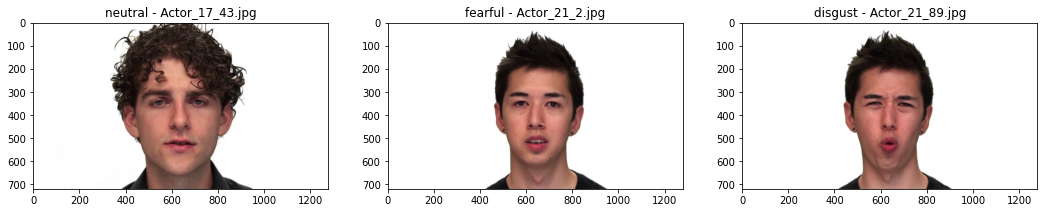

In [3]:

train_files =  glob('../data/03/original_size/train/*/**.jpg')
test_files =  glob('../data/03/original_size/test/*/**.jpg')

plt.figure(figsize=(18, 4))

for i in range(3):
    file = train_files[randint(0, len(train_files) -1 )]
    title_base = ' - '.join(file.split('/')[-2:])
    image = mpimg.imread(file)
    ax = plt.subplot(1, 3, i + 1)
    plt.title(title_base)
    plt.imshow(image)    
plt.show()

## Creating generators

In [4]:
data_folder = '../data/03/original_size'
base_dim = 48
batch_size = 64

train_data_gen = ImageDataGenerator(rescale=1./255)
val_data_gen = ImageDataGenerator(rescale=1./255)
test_data_gen = ImageDataGenerator(rescale=1./255)

train_generator = train_data_gen.flow_from_directory(
    os.path.join(data_folder, 'train'),
    target_size=(base_dim, base_dim),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='categorical'
)

val_generator = train_data_gen.flow_from_directory(
    os.path.join(data_folder, 'val'),
    target_size=(base_dim, base_dim),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='categorical'
)

test_generator = test_data_gen.flow_from_directory(
    os.path.join(data_folder, 'test'),
    target_size=(base_dim, base_dim),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='categorical'
)

Found 18225 images belonging to 8 classes.
Found 2275 images belonging to 8 classes.
Found 2287 images belonging to 8 classes.


## 1st CNN
### building model 

In [5]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(base_dim, base_dim, 1)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(8, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001, decay=1e-6), metrics=['accuracy'])

2022-08-03 15:19:25.455257: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-03 15:19:25.456226: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-03 15:19:25.457150: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-03 15:19:25.457625: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 22, 22, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 22, 22, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 128)      0         
 2D)                                                    

### Set callbacks

In [6]:
tensorboard_cb = TensorBoard(
    '../models/logs/ravdess', 
    histogram_freq=1
)

reduce_lr_cb = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=3,
    verbose=1,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0,
)

early_stopping_cb = EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=5,
    verbose=1,
    mode="auto",
    restore_best_weights=True,
)

callbacks = [
    tensorboard_cb,
    reduce_lr_cb,
    early_stopping_cb
]

In [8]:
model_info = model.fit(
    train_generator,
    # steps_per_epoch=len(train_files) // batch_size,
    epochs=50,
    validation_data=val_generator,
    callbacks=callbacks,
)

model_json = model.to_json()
if not os.path.exists('../models/ravdess'):
    os.makedirs('../models/ravdess/')
with open(f'../models/ravdess/model_{base_dim}x{base_dim}.json', 'w') as f:
    f.write(model_json)
    
model.save_weights(f'../models/ravdess/model_{base_dim}x{base_dim}.h5')

Epoch 1/50
285/285 [==============================] - ETA: 0s - loss: 1.6415 - accuracy: 0.3795

2022-08-03 15:23:14.626846: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 35389440 exceeds 10% of free system memory.
2022-08-03 15:23:14.675263: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 503316480 exceeds 10% of free system memory.


285/285 [==============================] - 116s 408ms/step - loss: 1.6415 - accuracy: 0.3795 - val_loss: 0.8245 - val_accuracy: 0.7099 - lr: 0.0010
Epoch 2/50
285/285 [==============================] - ETA: 0s - loss: 0.7363 - accuracy: 0.7427

2022-08-03 15:25:03.643645: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 35389440 exceeds 10% of free system memory.
2022-08-03 15:25:03.681716: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 503316480 exceeds 10% of free system memory.


285/285 [==============================] - 109s 381ms/step - loss: 0.7363 - accuracy: 0.7427 - val_loss: 0.2696 - val_accuracy: 0.9138 - lr: 0.0010
Epoch 3/50
285/285 [==============================] - ETA: 0s - loss: 0.4027 - accuracy: 0.8603

2022-08-03 15:26:51.009501: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 35389440 exceeds 10% of free system memory.


285/285 [==============================] - 107s 376ms/step - loss: 0.4027 - accuracy: 0.8603 - val_loss: 0.1605 - val_accuracy: 0.9543 - lr: 0.0010
Epoch 4/50
285/285 [==============================] - 100s 352ms/step - loss: 0.2693 - accuracy: 0.9083 - val_loss: 0.0894 - val_accuracy: 0.9741 - lr: 0.0010
Epoch 5/50
285/285 [==============================] - 106s 372ms/step - loss: 0.2048 - accuracy: 0.9324 - val_loss: 0.0553 - val_accuracy: 0.9851 - lr: 0.0010
Epoch 6/50
285/285 [==============================] - 115s 405ms/step - loss: 0.1569 - accuracy: 0.9477 - val_loss: 0.0544 - val_accuracy: 0.9846 - lr: 0.0010
Epoch 7/50
285/285 [==============================] - 114s 399ms/step - loss: 0.1273 - accuracy: 0.9570 - val_loss: 0.0328 - val_accuracy: 0.9925 - lr: 0.0010
Epoch 8/50
285/285 [==============================] - 113s 396ms/step - loss: 0.1114 - accuracy: 0.9612 - val_loss: 0.0485 - val_accuracy: 0.9859 - lr: 0.0010
Epoch 9/50
285/285 [==============================] - 116

In [6]:
classes = os.listdir('../data/03/original_size/train')
classes.sort()
classes

['angry', 'calm', 'disgust', 'fearful', 'happy', 'neutral', 'sad', 'surprised']

In [9]:
from tensorflow.keras.models import model_from_json

base_dim = 48

with open(f'../models/ravdess/model_{base_dim}x{base_dim}.json', 'r') as f:
    loaded_json = f.read()

model = model_from_json(loaded_json)
model.load_weights(f'../models/ravdess/model_{base_dim}x{base_dim}.h5')


2022-08-03 16:54:01.744746: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
predictions = model.predict(
    x=test_generator,
    max_queue_size=10,
    workers=8,
    use_multiprocessing=True,
    # callbacks=[tensorboard_cb]
)
preds = [classes[np.argmax(prediction)] for prediction in predictions]
trues = [classes[i] for i in test_generator.classes]

36/36 [==============================] - 6s 131ms/step


In [13]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(trues, preds))

              precision    recall  f1-score   support

       angry       0.13      0.13      0.13       306
        calm       0.15      0.15      0.15       293
     disgust       0.12      0.12      0.12       311
     fearful       0.13      0.13      0.13       277
       happy       0.12      0.12      0.12       286
     neutral       0.10      0.10      0.10       259
         sad       0.11      0.11      0.11       287
   surprised       0.12      0.12      0.12       268

    accuracy                           0.12      2287
   macro avg       0.12      0.12      0.12      2287
weighted avg       0.12      0.12      0.12      2287



In [16]:
confusion_matrix(trues, preds)

array([[39, 42, 37, 38, 41, 37, 39, 33],
       [39, 44, 45, 30, 37, 29, 37, 32],
       [42, 34, 37, 32, 40, 37, 45, 44],
       [45, 37, 26, 36, 40, 36, 37, 20],
       [28, 34, 44, 36, 35, 30, 36, 43],
       [36, 30, 36, 37, 34, 25, 31, 30],
       [35, 37, 51, 35, 30, 34, 31, 34],
       [45, 34, 35, 31, 29, 31, 31, 32]])

### Preprocessing steps

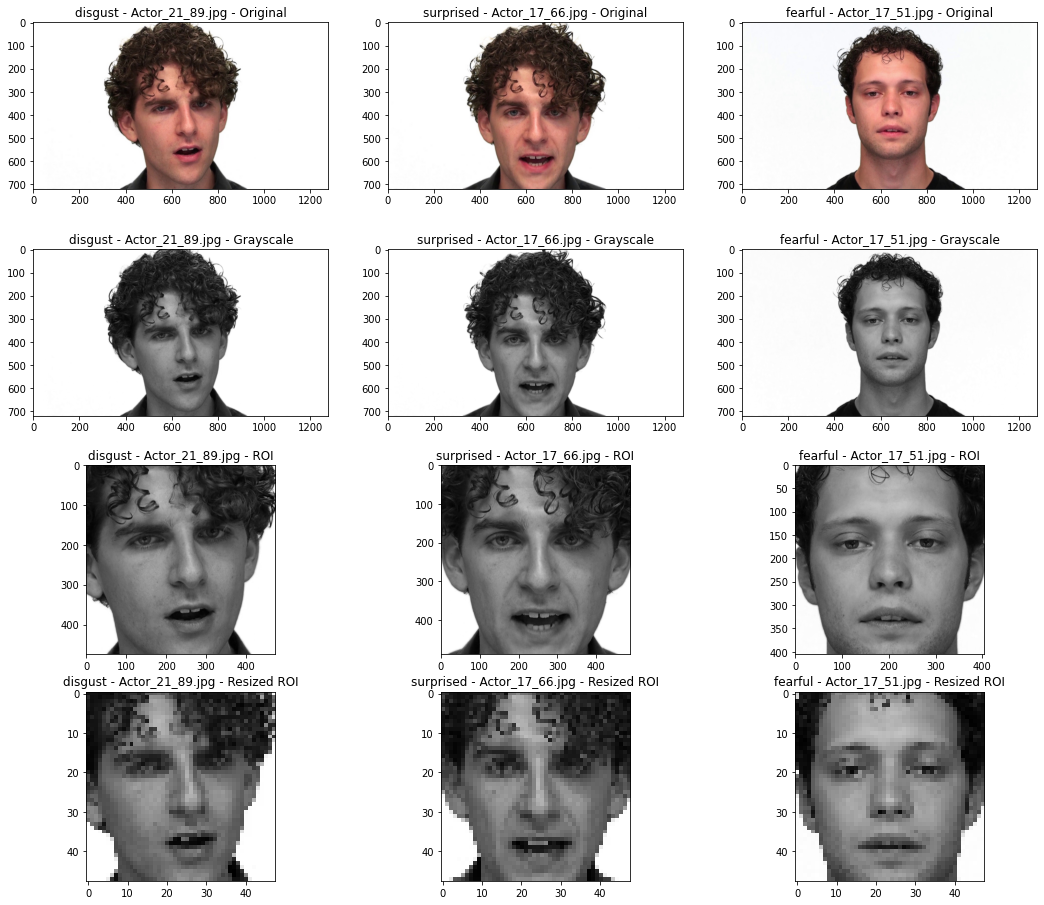

In [11]:
from random import choices
from matplotlib import cm

demo_imgs = choices(train_files, k=3)

# plt.figure(figsize=(20, 20))
fig, ax = plt.subplots(4, 3, figsize=(18, 16))
for i in range(len(demo_imgs)):
    title_base = ' - '.join(file.split('/')[-2:])
    file = demo_imgs[i]
    img = mpimg.imread(file)
    # Original images
    ax[0][i].set_title(f"{title_base} - Original")
    ax[0][i].imshow(img)
    
    # Grayscale images
    grayscale_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
    ax[1][i].set_title(f"{title_base} - Grayscale")
    ax[1][i].imshow(grayscale_image, cmap=cm.gray)
    
    # Cropped images (face detection)
    face_detector = cv2.CascadeClassifier('../haarcascades/haarcascade_frontalface_default.xml')
    faces = face_detector.detectMultiScale(grayscale_image, scaleFactor=1.3, minNeighbors=5)
    x, y, w, h = faces[0]
    roi_grayscale_img = grayscale_image[y:y + h, x:x + w]
    ax[2][i].set_title(f"{title_base} - ROI")
    ax[2][i].imshow(roi_grayscale_img, cmap=cm.gray)
    
    # Resized cropped images
    cropped_img = np.expand_dims(cv2.resize(roi_grayscale_img, (base_dim, base_dim)), -1)
    ax[3][i].set_title(f"{title_base} - Resized ROI")
    ax[3][i].imshow(cropped_img, cmap=cm.gray)
    
plt.show()

In [12]:
from numpy import ndarray
import pandas as pd 
from tqdm import tqdm
from glob import glob

test_files = glob(os.path.join(data_folder, 'test/*/**.jpg'))
columns = ['file', *classes, 'true', 'predicted']

results = pd.DataFrame(columns=columns)
fail_face_recognition = []

for file in tqdm(test_files):
    img = mpimg.imread(file)
    face_detector = cv2.CascadeClassifier('../haarcascades/haarcascade_frontalface_default.xml')
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_detector.detectMultiScale(gray_img, scaleFactor=1.3, minNeighbors=5)
    if len(faces) > 0 :
        x, y, w, h = faces[0]
        roi_gray_img = gray_img[y:y + h, x:x + w]
        cropped_img = np.expand_dims(np.expand_dims(cv2.resize(roi_gray_img, (48, 48)), -1), 0)
        predictions = model.predict(cropped_img, verbose=0)
    else:
        fail_face_recognition.append(file)
        predictions = model.predict(np.expand_dims(np.expand_dims(cv2.resize(gray_img, (48, 48)), -1), 0), verbose=0)
    predicted  = np.argmax(predictions[0])
    row = [[file], *[[p] for p in predictions[0]], [file.split('/')[-2]], [classes[predicted]]]
    dict_row = dict(zip(columns, row))
    tmp_results = pd.DataFrame(dict_row)
    results = pd.concat([results, tmp_results])

100%|██████████| 2287/2287 [04:45<00:00,  8.00it/s]


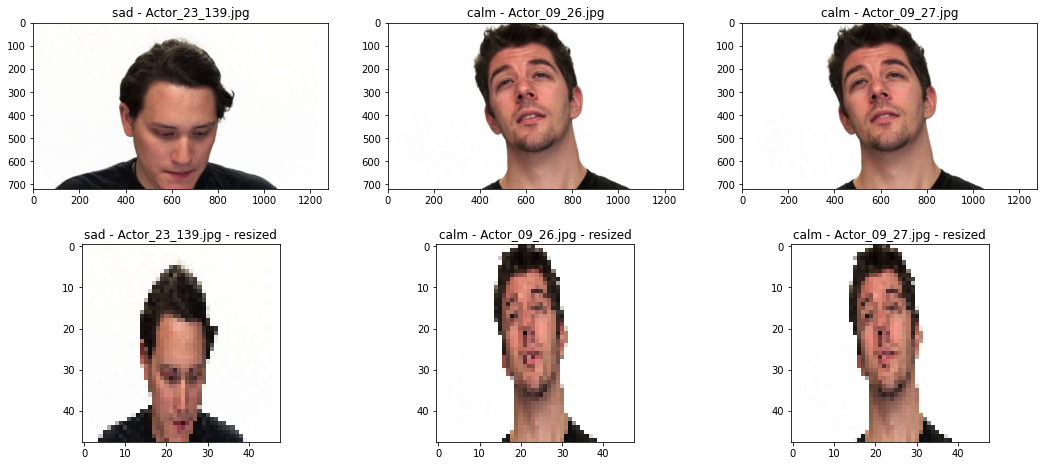

In [13]:
n_rows = len(fail_face_recognition) // 3 + 1

plt.figure(figsize=(18, 4 * n_rows))
index = 1

for i in range(len(fail_face_recognition)):
    file = fail_face_recognition[i]
    title_base = ' - '.join(file.split('/')[-2:])
    image = mpimg.imread(file)
    plt.subplot(n_rows, 3, index)
    plt.title(title_base)
    plt.imshow(image)
    plt.subplot(n_rows, 3, index + 3)
    plt.title(f"{title_base} - resized")
    plt.imshow(cv2.resize(image, (48, 48)))
    index += 1
plt.show()

In [14]:
results.sample(5)

,file,angry,calm,disgust,fearful,happy,neutral,sad,surprised,true,predicted
0,../data/03/original_size/test/angry/Actor_16_0...,1.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,angry,angry
0,../data/03/original_size/test/angry/Actor_04_6...,1.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,angry,angry
0,../data/03/original_size/test/fearful/Actor_18...,0.0,0.0,1.0,1.339296e-09,0.0,0.0,0.0,0.0,fearful,disgust
0,../data/03/original_size/test/fearful/Actor_16...,1.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,fearful,angry
0,../data/03/original_size/test/happy/Actor_17_6...,0.0,0.0,0.0,1.000000e+00,0.0,0.0,0.0,0.0,happy,fearful


In [16]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(results['true'], results['predicted']))

              precision    recall  f1-score   support

       angry       0.15      0.49      0.22       306
        calm       0.33      0.01      0.01       293
     disgust       0.20      0.12      0.15       311
     fearful       0.13      0.43      0.20       277
       happy       0.11      0.03      0.05       286
     neutral       0.00      0.00      0.00       259
         sad       0.33      0.03      0.06       287
   surprised       0.19      0.03      0.06       268

    accuracy                           0.15      2287
   macro avg       0.18      0.14      0.09      2287
weighted avg       0.18      0.15      0.10      2287



/home/gio/Dev/listen_yourself/env385/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gio/Dev/listen_yourself/env385/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gio/Dev/listen_yourself/env385/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

### 1st Model results

+ Train accuracy:      0.9966  
+ Validation accuracy: 0.9978
+ Test accuracy :      0.1407

It looks like something is going wrong.

It totally underperform on test.

That can be caused by an overcomplicated model, unable to generalize to unseen datas

In [19]:
confusion_matrix(results['true'], results['predicted'])

array([[150,   1,  27, 113,   6,   0,   1,   8],
       [145,   2,  11, 119,  12,   0,   0,   4],
       [150,   0,  36,  99,  12,   0,  12,   2],
       [120,   1,  13, 118,  14,   0,   4,   7],
       [125,   0,  24, 119,   9,   0,   2,   7],
       [116,   0,  11, 122,   9,   0,   0,   1],
       [107,   2,  37, 105,  16,   0,  10,  10],
       [119,   0,  18, 115,   6,   0,   1,   9]])

### Test on video stream

In [ ]:
import os
from tabnanny import verbose
import cv2
# import skvideo.io
from glob import glob
import numpy as np
from random import randint

videos = glob('../data/test_face_recognition/*.mp4')
rdm_video = videos[randint(0, len(videos) - 1)]
cap = cv2.VideoCapture(rdm_video)
while True:
    success, frame = cap.read()
    if not success:
        break
    frame = cv2.resize(frame, (640, 480))
    face_detector = cv2.CascadeClassifier('../haarcascades/haarcascade_frontalface_default.xml')
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    faces = face_detector.detectMultiScale(gray_frame, scaleFactor=1.3, minNeighbors=5)
    
    for (x, y, w, h) in faces:
        cv2.rectangle(frame, (x, y - 50), (x + w, y + h + 10), (0, 255, 0), 4)
        roi_gray_frame = gray_frame[y:y + h, x:x + w]
        cropped_img = np.expand_dims(np.expand_dims(cv2.resize(roi_gray_frame, (48, 48)), -1), 0)
        prediction = model.predict(cropped_img, verbose=0)
        # print(dict(zip(emotions_dict.keys(), prediction[0])))
        max_index = int(np.argmax(prediction))
        cv2.putText(frame, emotions_dict[max_index], (x + 5, y - 20), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)
    cv2.imshow(f'Emotion Detection : {os.path.basename(rdm_video)}', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    
cap.release()